In [23]:
#Building Models to Predict Winners based on Certain Features

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from itertools import combinations
from collections import defaultdict


#Read dataset
df = pd.read_csv('atp_matches_2023.csv')

In [24]:
#Preparing Data

#Sort by date for accurate recent form tracking
df_sorted = df.sort_values('tourney_date')

#Build recent performance (wins in last 5 matches)
recent_wins = defaultdict(list)
winner_form = []
loser_form = []

for _, row in df_sorted.iterrows():
    wid, lid = row['winner_id'], row['loser_id']
    winner_form.append(sum(recent_wins[wid][-5:]))
    loser_form.append(sum(recent_wins[lid][-5:]))
    recent_wins[wid].append(1)
    recent_wins[lid].append(0)

#Add recent form to dataframe
df_sorted['winner_form'] = winner_form
df_sorted['loser_form'] = loser_form

#Drop rows with missing values in relevant columns
features = ['winner_age', 'winner_ht', 'winner_hand', 'winner_ioc',
            'loser_age', 'loser_ht', 'loser_hand', 'loser_ioc',
            'winner_form', 'loser_form']

clean_df = df_sorted.dropna(subset=features).copy()

#Encode categorical variables
for col in ['winner_hand', 'winner_ioc', 'loser_hand', 'loser_ioc']:
    encoder = LabelEncoder()
    clean_df[col] = encoder.fit_transform(clean_df[col])

#Create difference-based features
clean_df['age_diff'] = clean_df['winner_age'] - clean_df['loser_age']
clean_df['ht_diff'] = clean_df['winner_ht'] - clean_df['loser_ht']
clean_df['hand_diff'] = clean_df['winner_hand'] - clean_df['loser_hand']
clean_df['ioc_diff'] = clean_df['winner_ioc'] - clean_df['loser_ioc']
clean_df['form_diff'] = clean_df['winner_form'] - clean_df['loser_form']

#Feature matrix and labels
X = clean_df[['age_diff', 'ht_diff', 'hand_diff', 'ioc_diff', 'form_diff']]
y = [1] * len(X)

#Mirror the dataset for the other player
X_mirror = -X
y_mirror = [0] * len(X)

#Combine original and mirrored data
X_final = pd.concat([X, X_mirror], ignore_index=True)
y_final = y + y_mirror

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

In [25]:
#Logistic Regression Model

#Train logistic regression model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

#Evaluate
log_accuracy = accuracy_score(y_test, log_model.predict(X_test))
print(f"Logistic Regression Accuracy: {log_accuracy:.4f}")

Logistic Regression Accuracy: 0.6154


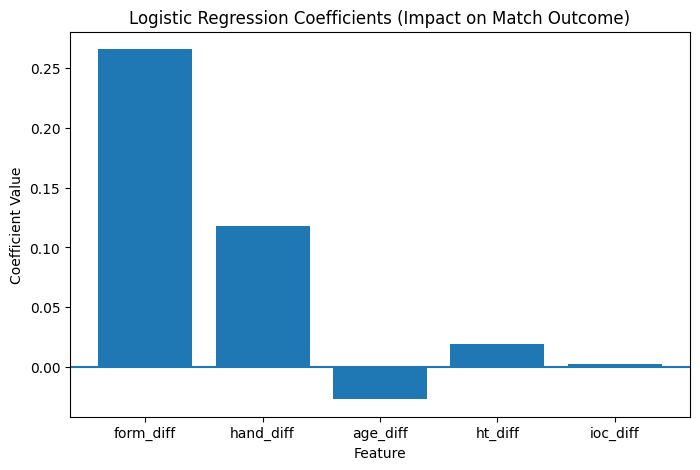

In [35]:
#Which variable matters the most using the logistic regression model

#Feature names used in the logistic regression model
feature_names = ['age_diff', 'ht_diff', 'hand_diff', 'ioc_diff', 'form_diff']

#Extract coefficients from the trained logistic regression model
log_coefficients = log_model.coef_[0]

#Create a DataFrame
log_coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': log_coefficients
})

#Sort by absolute value to find most impactful features
log_coef_df = log_coef_df.sort_values(by='Coefficient', key=abs, ascending=False)

#Plot coefficients
plt.figure(figsize=(8, 5))
plt.bar(log_coef_df['Feature'], log_coef_df['Coefficient'])
plt.axhline(0)
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('Logistic Regression Coefficients (Impact on Match Outcome)')
plt.show()

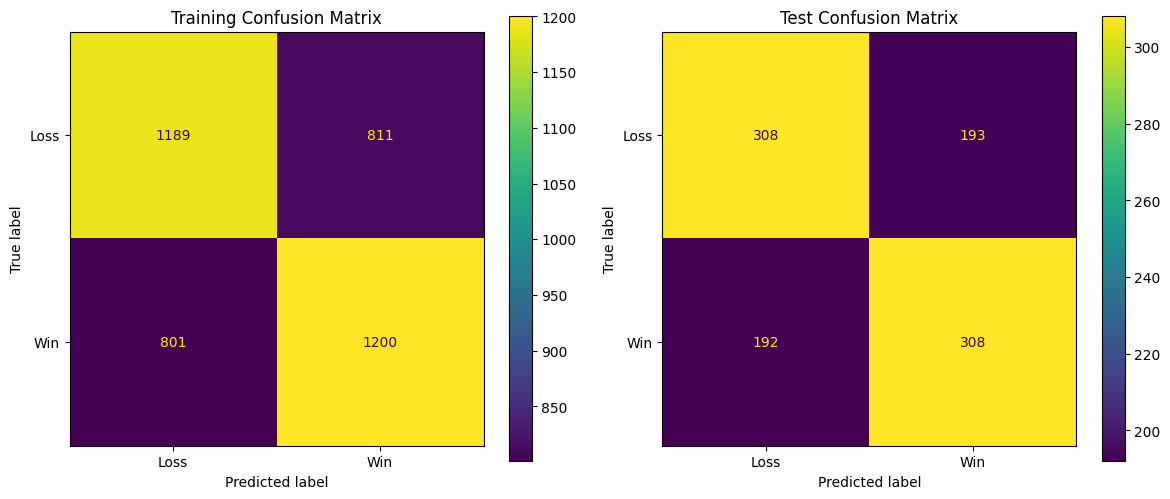

In [36]:
#Predict on training and test data
y_train_pred = log_model.predict(X_train)
y_test_pred = log_model.predict(X_test)

#Compute confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

#Create side-by-side plots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

#Training confusion matrix
ConfusionMatrixDisplay(cm_train, display_labels=["Loss", "Win"]).plot(ax=ax[0], values_format='d')
ax[0].set_title('Training Confusion Matrix')

#Test confusion matrix
ConfusionMatrixDisplay(cm_test, display_labels=["Loss", "Win"]).plot(ax=ax[1], values_format='d')
ax[1].set_title('Test Confusion Matrix')

plt.tight_layout()
plt.show()


In [31]:
#Random Forest Model

#Train random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

#Evaluate
rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test))
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

Random Forest Accuracy: 0.5944


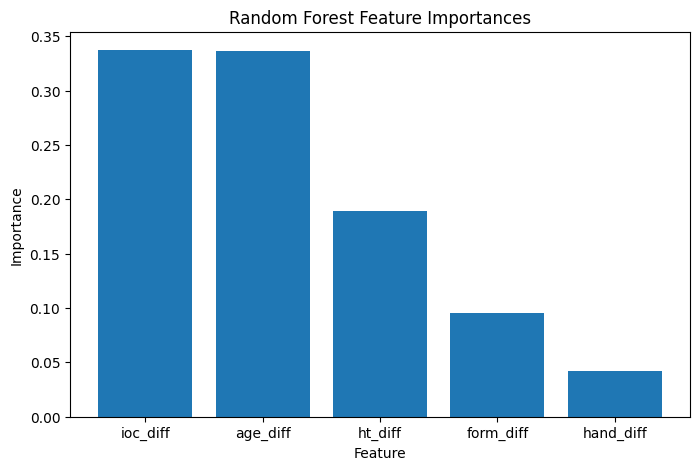

In [39]:
#Which variable matters most for the random forest model

#Define feature names
rf_feature_names = ['age_diff', 'ht_diff', 'hand_diff', 'ioc_diff', 'form_diff']

#Extract feature importances from the trained Random Forest model
rf_importances = rf_model.feature_importances_

#Create a DataFrame
rf_importance_df = pd.DataFrame({
    'Feature': rf_feature_names,
    'Importance': rf_importances
})

#Sort by importance
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)

#Plot the feature importances
plt.figure(figsize=(8, 5))
plt.bar(rf_importance_df['Feature'], rf_importance_df['Importance'])
plt.title('Random Forest Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

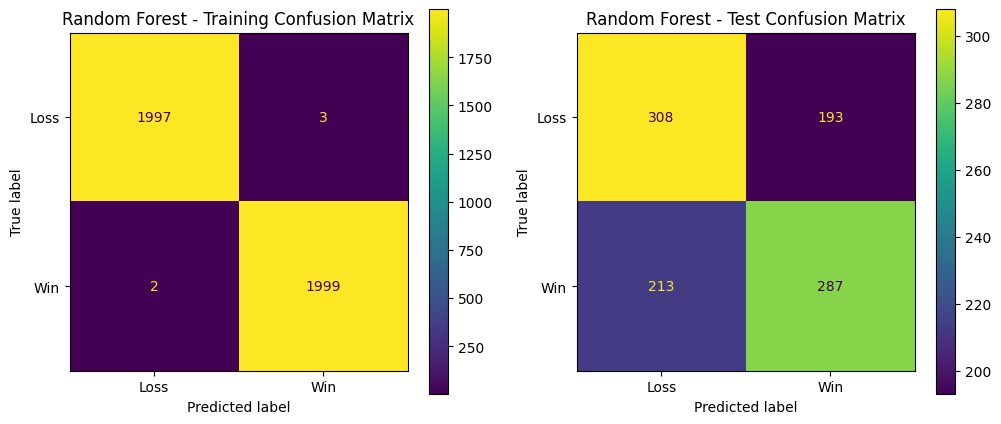

In [40]:
#Predict on training and test datasets
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

#Compute confusion matrices
cm_train_rf = confusion_matrix(y_train, y_train_pred_rf)
cm_test_rf = confusion_matrix(y_test, y_test_pred_rf)

#Plot side-by-side confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

#Training confusion matrix
ConfusionMatrixDisplay(cm_train_rf, display_labels=["Loss", "Win"]).plot(ax=ax[0], values_format='d')
ax[0].set_title('Random Forest - Training Confusion Matrix')

#Test confusion matrix
ConfusionMatrixDisplay(cm_test_rf, display_labels=["Loss", "Win"]).plot(ax=ax[1], values_format='d')
ax[1].set_title('Random Forest - Test Confusion Matrix')

plt.show()

In [27]:
#Decision Tree Model

#Train decision tree model
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

#Evaluate
dt_accuracy = accuracy_score(y_test, dt_model.predict(X_test))
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")

Decision Tree Accuracy: 0.6074


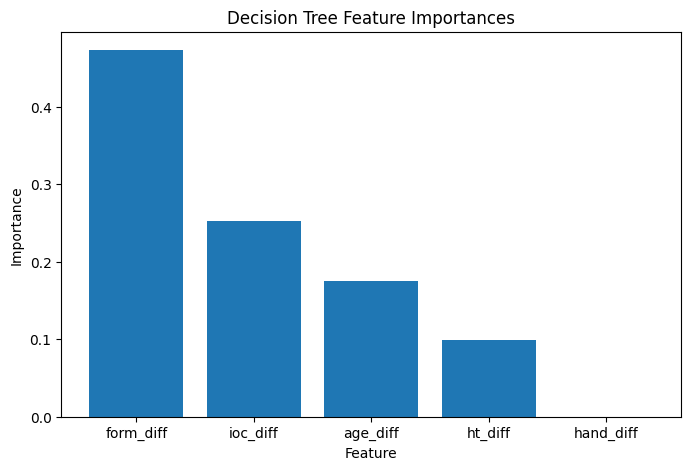

In [43]:
#Which variable matters most for the decision tree model

#Define the feature names
dt_feature_names = ['age_diff', 'ht_diff', 'hand_diff', 'ioc_diff', 'form_diff']

#Extract feature importances from the Decision Tree model
dt_importances = dt_model.feature_importances_

#Create a DataFrame
dt_importance_df = pd.DataFrame({
    'Feature': dt_feature_names,
    'Importance': dt_importances
})

#Sort features by importance
dt_importance_df = dt_importance_df.sort_values(by='Importance', ascending=False)

#Plot the feature importances
plt.figure(figsize=(8, 5))
plt.bar(dt_importance_df['Feature'], dt_importance_df['Importance'])
plt.title('Decision Tree Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()


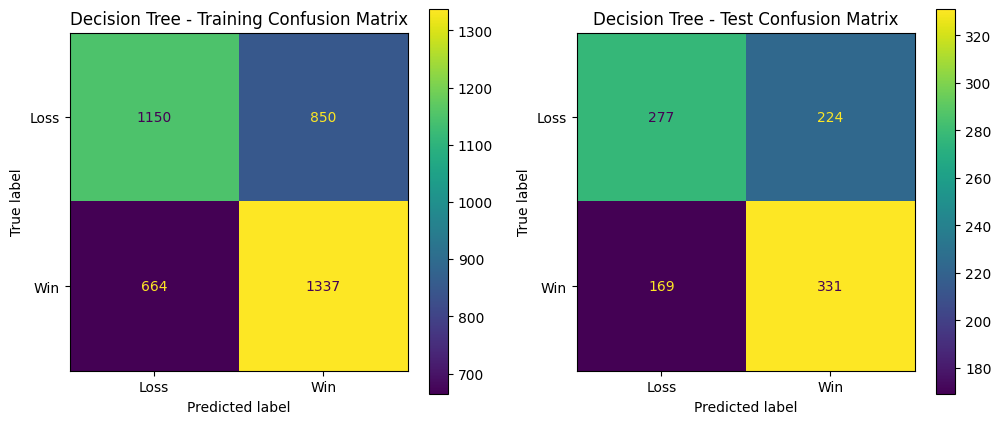

In [44]:
#Predict on training and test datasets
y_train_pred_dt = dt_model.predict(X_train)
y_test_pred_dt = dt_model.predict(X_test)

#Compute confusion matrices
cm_train_dt = confusion_matrix(y_train, y_train_pred_dt)
cm_test_dt = confusion_matrix(y_test, y_test_pred_dt)

#Plot side-by-side confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

#Training confusion matrix
ConfusionMatrixDisplay(cm_train_dt, display_labels=["Loss", "Win"]).plot(ax=ax[0], values_format='d')
ax[0].set_title('Decision Tree - Training Confusion Matrix')

#Test confusion matrix
ConfusionMatrixDisplay(cm_test_dt, display_labels=["Loss", "Win"]).plot(ax=ax[1], values_format='d')
ax[1].set_title('Decision Tree - Test Confusion Matrix')

plt.show()